In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
#from sklearn.metrics import mean_squared_error
#from scipy.stats import norm
#from scipy.optimize import curve_fit
#from scipy.optimize import fsolve
import matplotlib.pyplot as plt
#%matplotlib inline+
import folium
import json
import urllib.request

url_B = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
url_G = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"

# BR / Brasil - geojson/geojs-100-mun.json
# AL / Alagoas - geojson/geojs-27-mun.json
# BA / Bahia - geojson/geojs-29-mun.json
# CE / Ceará - geojson/geojs-23-mun.json
# MA / Maranhão - geojson/geojs-21-mun.json
# PB / Paraíba - geojson/geojs-25-mun.json
# PE / Pernambuco - geojson/geojs-26-mun.json
# PI / Piauí - geojson/geojs-22-mun.json
# RN / Rio Grande do Norte - geojson/geojs-24-mun.json
# SE / Sergipe - geojson/geojs-28-mun.json

In [2]:
df = pd.read_csv(url_B, sep = ",")
df1 = df.drop(['epidemiological_week', 'last_available_date', 'is_repeated'], axis = 1)
df1.rename(columns={'last_available_confirmed' : 'confirmed', 'last_available_confirmed_per_100k_inhabitants' : 'incidence',
                    'estimated_population_2019' : 'population','last_available_deaths' : 'deaths',
                    'last_available_death_rate' : 'death_rate'}, inplace = True)

In [3]:
req = urllib.request.urlopen(url_G)
content = req.read().decode('ansi')

geo = json.loads(content)

In [4]:
df_hoje = df1.loc[df['is_last'] == True, :]

label = ["Cidade", "Código IBGE", "Dia", "Último Dado", "Casos Confirmados", "Incidência de Casos", "Mortalidade", "Óbitos Confirmados", "Estado", "Novos Casos", "Novas Mortes"]
color = ['#e8615d', '#f49436', '#2d9de5', '#3bbdbd', '#634792']

In [5]:
FMT = '%Y-%m-%d'

date = df['date']
df1['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-25", FMT)).days)

In [6]:
Norte = ["AC", "AM", "AP", "PA", "RO", "RR", "TO"]
Nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
Sudeste = ['ES', 'MG', 'RJ', 'SP']
Sul = ['PR', 'RS', 'SC']
Centro_oeste = ['DF', 'GO', 'MT', 'MS']

Regiao = [Nordeste, Norte, Sudeste, Sul, Centro_oeste]
reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

In [7]:
df_estados = df1.loc[df['city'].isnull(), :].drop(['place_type', 'order_for_place'], axis = 1)
df_estados.reset_index(drop = True, inplace = True)

df_estados['incidence'] = 'null'
df_estados['death_rate'] = 'null'

for r in range(len(Regiao)) :
    for a in range(len(Regiao[r])) :
        df_estados.loc[df_estados['state'].eq(Regiao[r][a]), 'region'] = reg[r]

for i in range(len(df_estados)) :
    df_estados.loc[i, 'incidence'] = round(100000 * df_estados.loc[i, 'confirmed'] / df_estados.loc[i, 'population'], 2)
    if df_estados.loc[i, 'confirmed'] != 0 :
        df_estados.loc[i, 'death_rate'] = round(100 * df_estados.loc[i, 'deaths'] / df_estados.loc[i, 'confirmed'], 2)

df_estados = df_estados[['state', 'region', 'population', 'is_last', 'date',
                         'confirmed', 'deaths', 'new_confirmed', 'new_deaths', 'incidence', 'death_rate']]         
        
df_Brasil = df_estados.drop(['is_last', 'population'], axis = 1)
df_Brasil = df_Brasil.groupby('date').sum()

In [8]:
df_cidades = df1.loc[df['place_type'].eq('city'), :].drop(['place_type', 'order_for_place'], axis = 1)

df_cidades['region'] = 'null'
for r in range(len(Regiao)) :
    for a in range(len(Regiao[r])) :
        df_cidades.loc[df_cidades['state'].eq(Regiao[r][a]), 'region'] = reg[r]        

df_cidades = df_cidades[['city', 'state', 'region', 'population', 'is_last', 'date',
                         'confirmed', 'deaths', 'new_confirmed', 'new_deaths']]

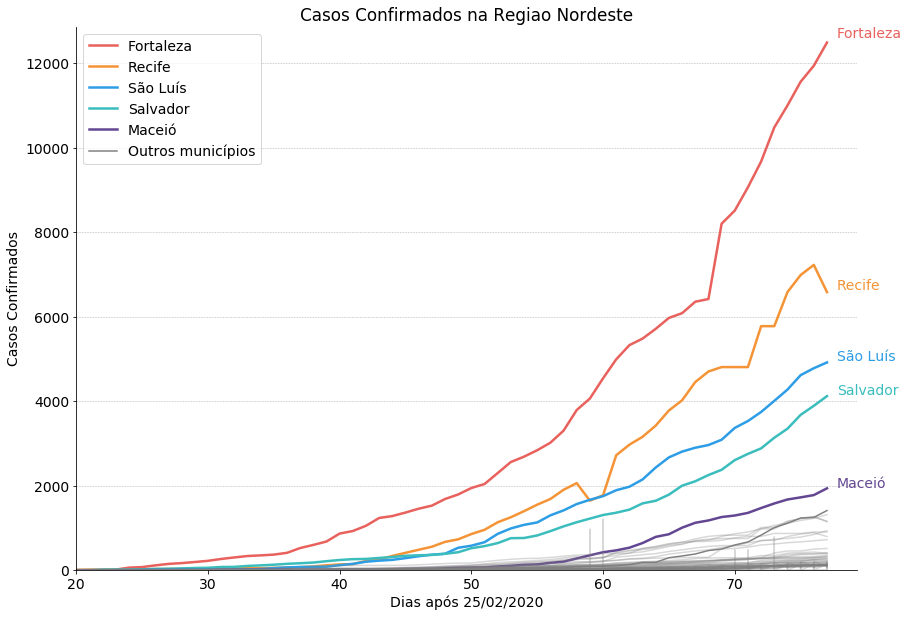

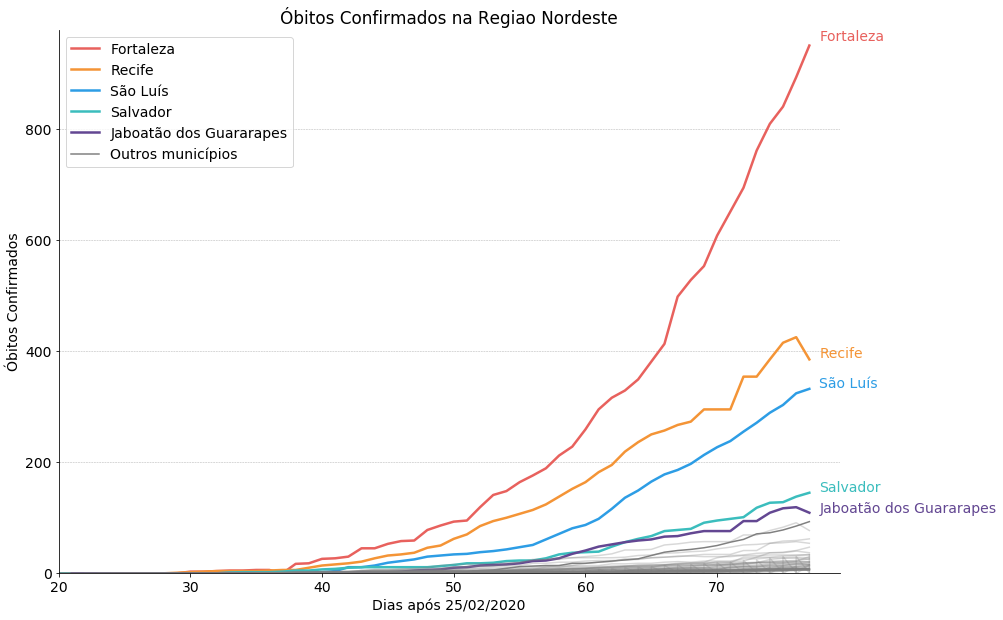

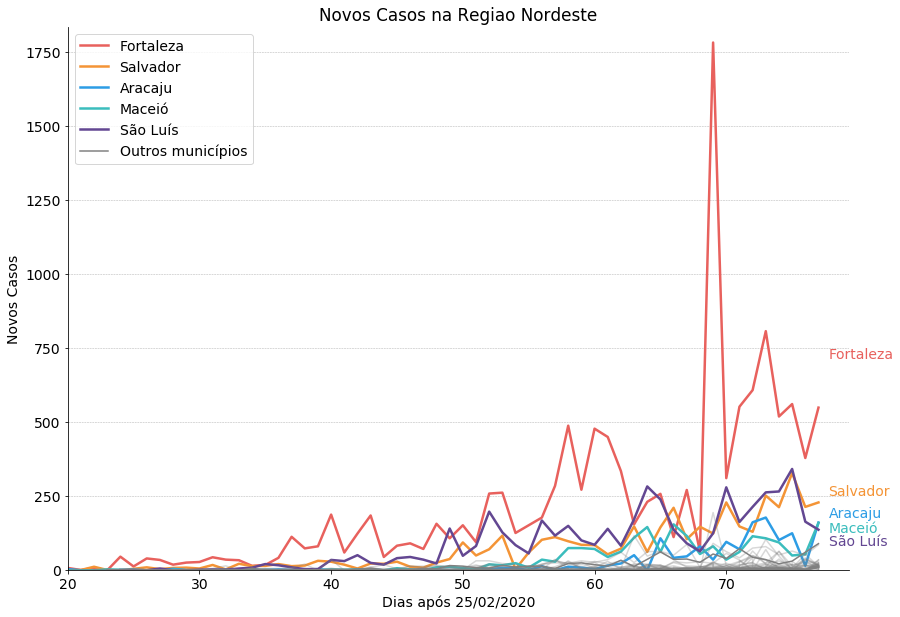

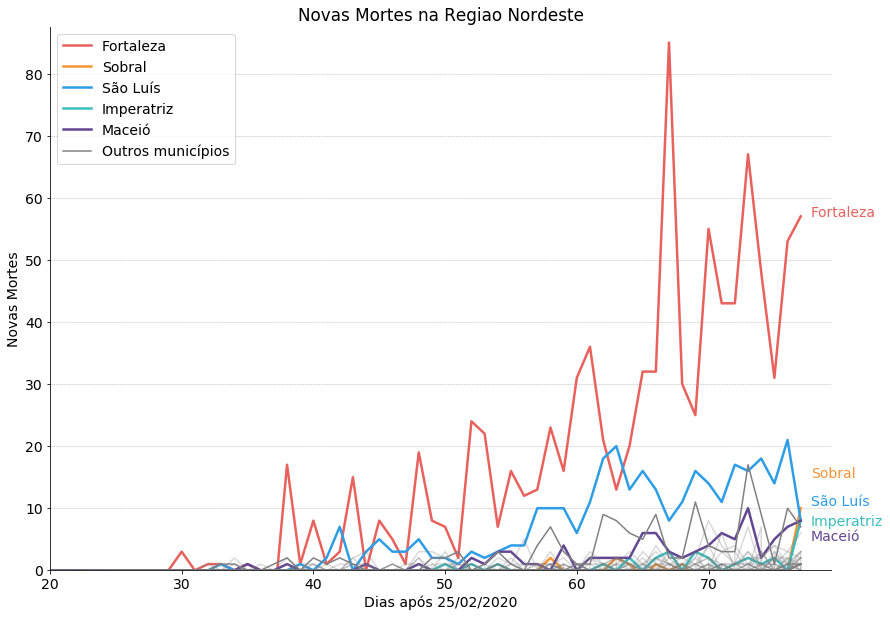

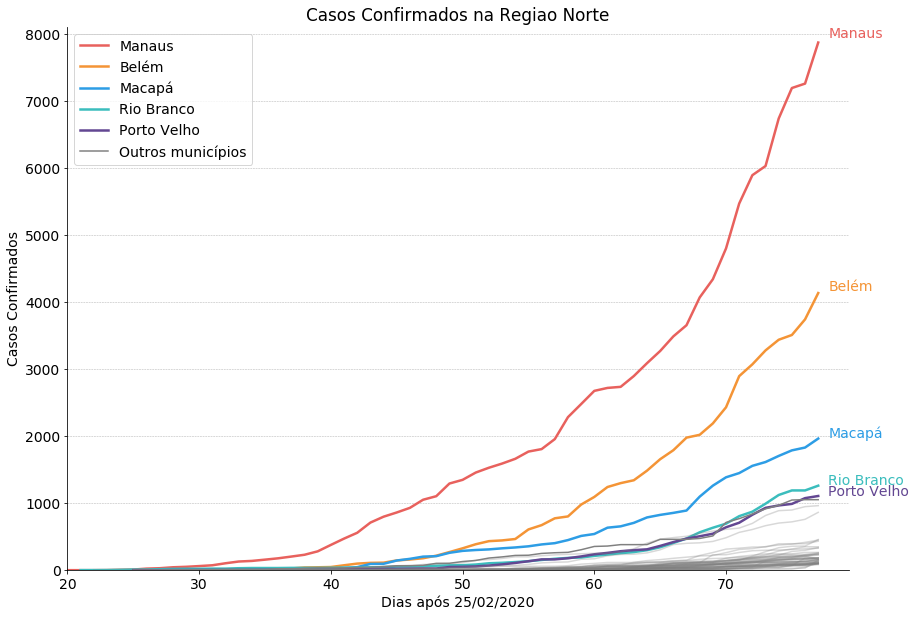

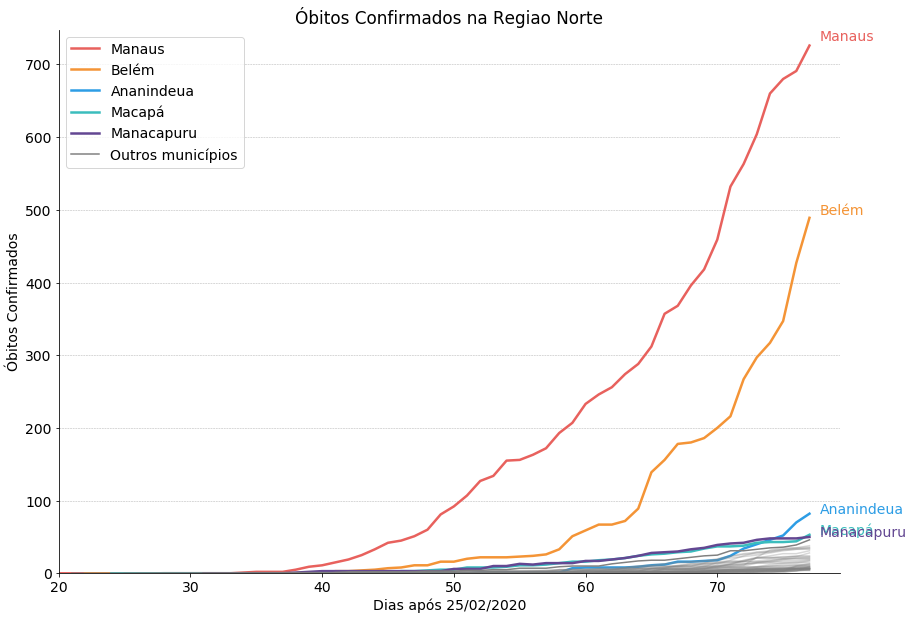

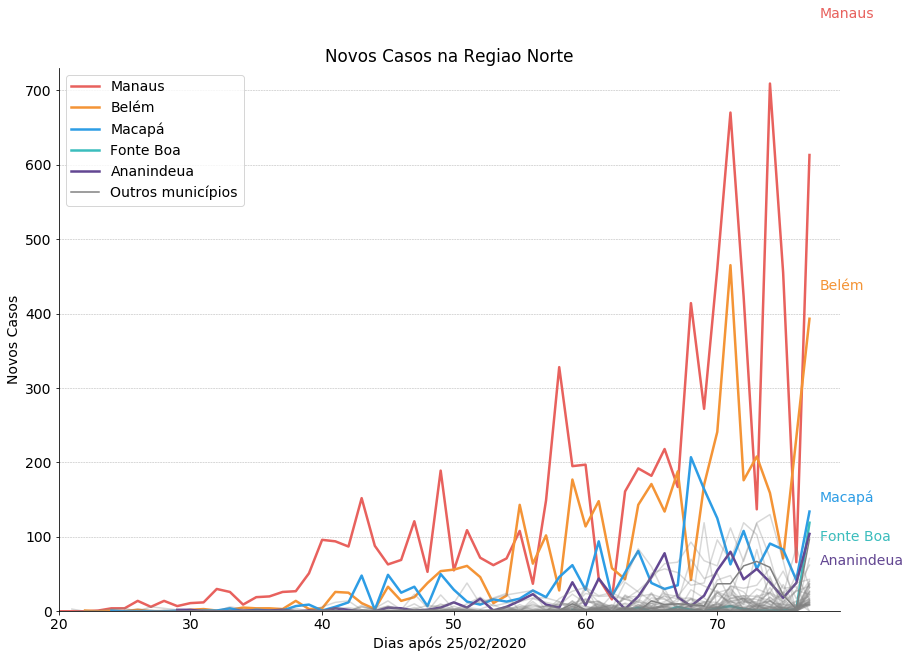

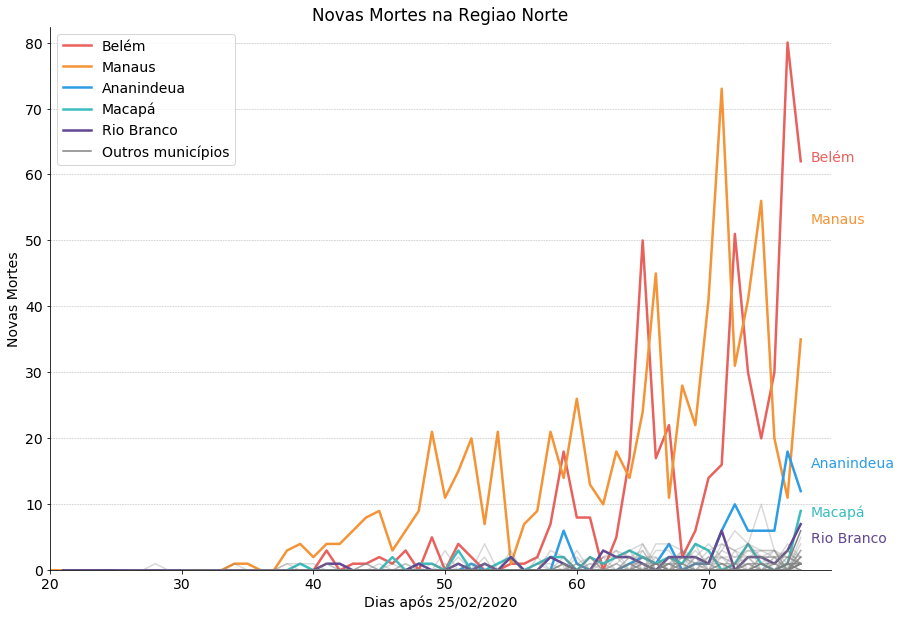

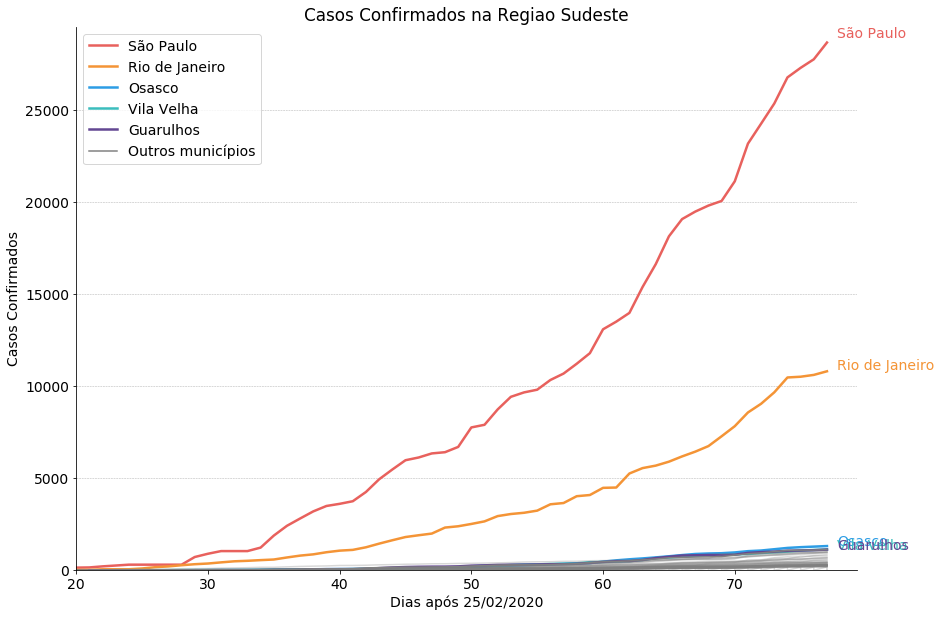

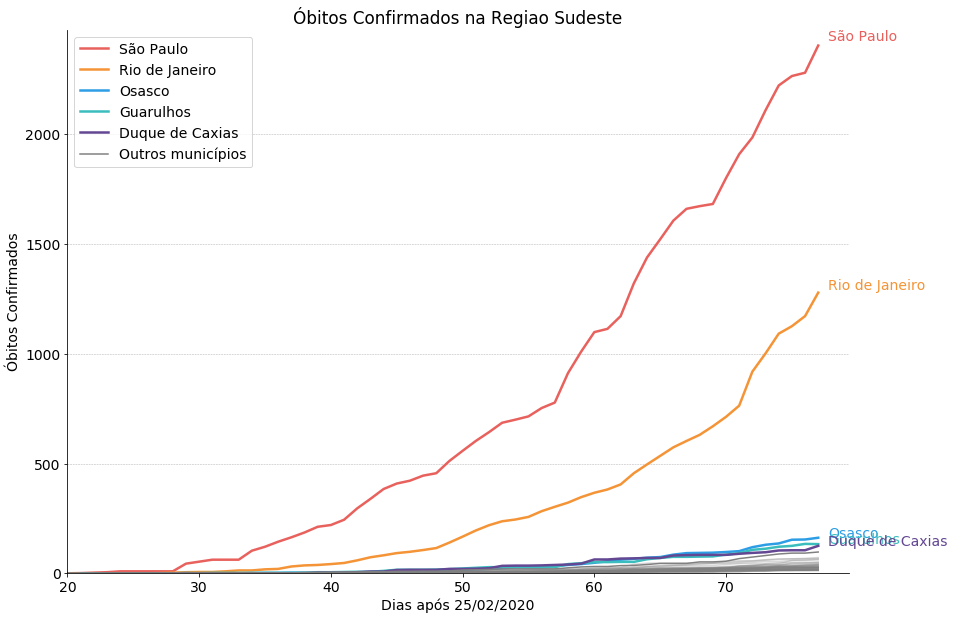

KeyboardInterrupt: 

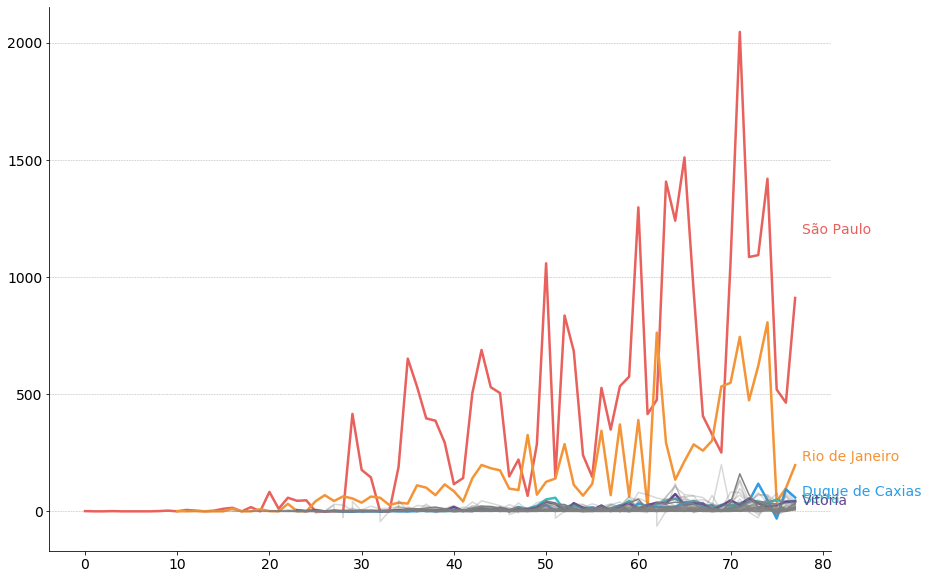

In [18]:
label = ["Cidade", "Estado", "Região", "População", "Último dado", "Dia", "Casos Confirmados", 
           "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]
dia = max(df_Brasil.index)
reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']
ytab = [[0], [0], [0], [0], [0], [0],
        [1.3, 1.1, 1, .9, .6], [1.3, 1.1, 1, .9, .6],
        [1.3, 1.1, 1.1, .8, .6], [1, 1.5, 1.3, .9, .6]]

for r in range(5) :
    for f in range(6, 10) :
        x_max = dia
        y_max = 0 
        
        plt.rc('font', size = 14)
        plt.rcParams['figure.figsize'] = [14, 10]
        plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                        labelbottom = "on", left = "off", right = "off", labelleft = "on")
        
        plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
        plt.gca().spines["top"].set_visible(False)    
        plt.gca().spines["right"].set_visible(False)
        plt.gca().get_xaxis().tick_bottom()    
        plt.gca().get_yaxis().tick_left()        

        Regiao_c = list(df_cidades[(df_cidades['region'] == reg[r]) &
                           (df_cidades['is_last'])].sort_values(df_cidades.columns[f],
                                                                ascending = False)['city'].unique())
        if f in [6, 7] :
           
            for c in range(len(Regiao_c)) : 
                # Real data
                x = list(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                        (df_cidades['city'] == Regiao_c[c]) , :].iloc[:, 5])
                y = list(df_cidades.loc[(df_cidades['region'] == reg[r]) & 
                                        (df_cidades['city'] == Regiao_c[c]) , :].iloc[:, f])

                if max(x) > x_max :
                    x_max = max(x)
                if max(y) > y_max :
                    y_max = max(y)            

                if (c > 5) & (c < 50) :
                    plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)
                elif c == 5 :
                    plt.plot(x, y, marker = ' ', label = 'Outros municípios', color = 'gray', lw = 1.5)
                elif c < 5 :
                    plt.plot(x, y, marker = ' ', label = Regiao_c[c], color = color[c], lw = 2.5)
                    plt.text(x_max * 1.01, y[-1] * 1.01, Regiao_c[c], color = color[c], fontsize = 14) 
    
            plt.xlim(20, x_max * 1.03)
            plt.ylim(0, y_max * 1.03)
            
        if f in [8, 9] :
             
            for c in range(len(Regiao_c)) : 
                # Real data
                x = list(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                        (df_cidades['city'] == Regiao_c[c]) , :].iloc[:, 5])
                y = list(df_cidades.loc[(df_cidades['region'] == reg[r]) & 
                                        (df_cidades['city'] == Regiao_c[c]) , :].iloc[:, f])
                
                
                
                if max(x) > x_max :
                    x_max = max(x)
                if max(y) > y_max :
                    y_max = max(y)            

                if (c > 5) & (c < 50) :
                    plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)
                elif c == 5 :
                    plt.plot(x, y, marker = ' ', label = 'Outros municípios', color = 'gray', lw = 1.5)
                elif c < 5 :
                    plt.plot(x, y, marker = ' ', label = Regiao_c[c], color = color[c], lw = 2.5)
                    if y[-1] > 0 :
                        plt.text(max(x) * 1.01, y[-1] * ytab[f][c], Regiao_c[c], color = color[c], fontsize = 14)
                    elif y[-2] > 0 :
                        plt.text(max(x) * 1.01, y[-2] * ytab[f][c], Regiao_c[c], color = color[c], fontsize = 14)
                    elif y[-3] > 0 :
                        plt.text(max(x) * 1.01, y[-3] * ytab[f][c], Regiao_c[c], color = color[c], fontsize = 14)
    
            plt.xlim(20, x_max * 1.03)
            plt.ylim(0, y_max * 1.03) 

        plt.title(label[f] + " na Regiao " + reg[r])
        plt.legend(loc = 2)
        #plt.yscale('log')
        plt.xlabel("Dias após 25/02/2020")
        plt.ylabel(label[f])
        plt.savefig('Graphics/' + label[f] + " - " + reg[r] + ".png")
        plt.show()

In [10]:
df_hoje = df1.loc[(df["is_last"] == True), :].drop(['date', 'is_last'], axis = 1)
df_hoje = df_hoje.loc[(df_hoje["place_type"] == 'city'), :]
df_hoje = df_hoje.loc[(df_hoje["city"] != 'Importados/Indefinidos'), :]
df_hoje['city_ibge_code'] = df_hoje['city_ibge_code'].astype(int).astype(str)

In [ ]:
m = folium.Map(
    name = 'COVID19 Brasil',
    width = 800, height = 500,
    location = [-15.77972, -47.92972], #[-7, -36.75], # centro paraiba 
    zoom_start = 4,
    min_zoom = 3,
    max_zoom = 18,
    tiles = 'Mapbox Bright'#'cartodbpositron'
)

m.choropleth(
    geo_data = geo,
    name = 'Casos Confirmados',
    data = df_hoje,
    columns = ['city_ibge_code', 'confirmed'],
    key_on = 'feature.properties.id',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Casos Confirmados',
    legend_fontsize = '14',
    bins = [0, 10, 100, 1000, 10000, 100000]
)

m.choropleth(
    geo_data = geo,
    name = 'Óbitos Confirmados',
    data = df_hoje,
    columns = ['city_ibge_code', 'deaths'],
    key_on = 'feature.properties.id',
    fill_color = 'Reds',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Óbitos Confirmados',
    legend_fontsize = '14',
    bins = [0, 1, 10, 100, 1000, 10000],
    show = False
)

m.choropleth(
    geo_data = geo,
    name = 'Casos Confirmados por 100 mil habitantes',
    data = df_hoje,
    columns = ['city_ibge_code', 'incidence'],
    key_on = 'feature.properties.id',
    fill_color = 'PuRd',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Casos Confirmados por 100 mil habitantes',
    legend_fontsize = '14',
    bins = [0, 1, 10, 100, 1000, 2000],
    show = False
)

bins = list(df_hoje['death_rate'].quantile([0, .125, .25, .375, .5, .625, .75, .875, 1]))
m.choropleth(
    geo_data = geo,
    name = 'Mortalidade',
    data = df_hoje,
    columns = ['city_ibge_code', 'death_rate'],
    key_on = 'feature.properties.id',
    fill_color = 'RdPu',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Mortalidade',
    legend_fontsize = '14',
    bins = bins,
    show = False
)
folium.LayerControl(name = 'COVID19 Brasil').add_to(m)

m.save('mapa.html')
m

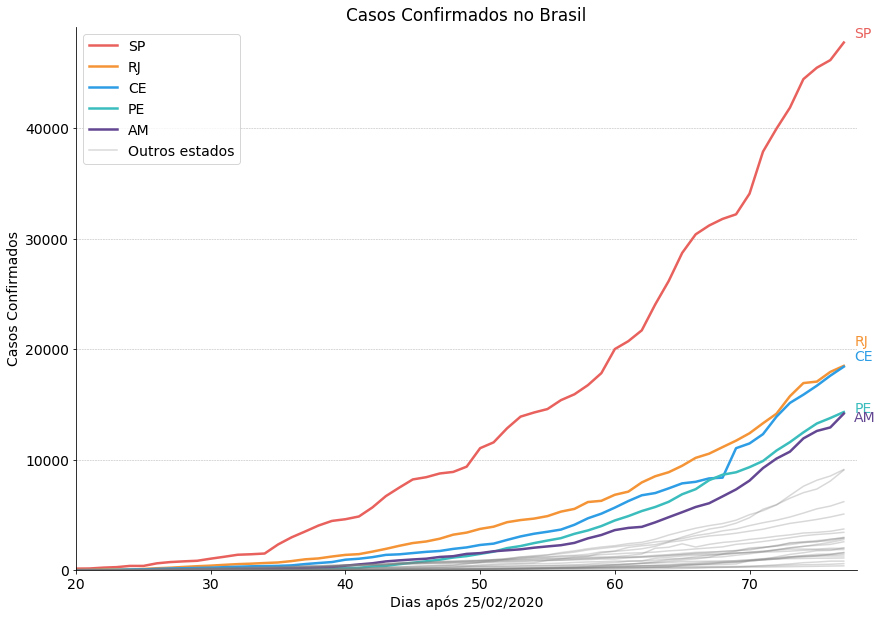

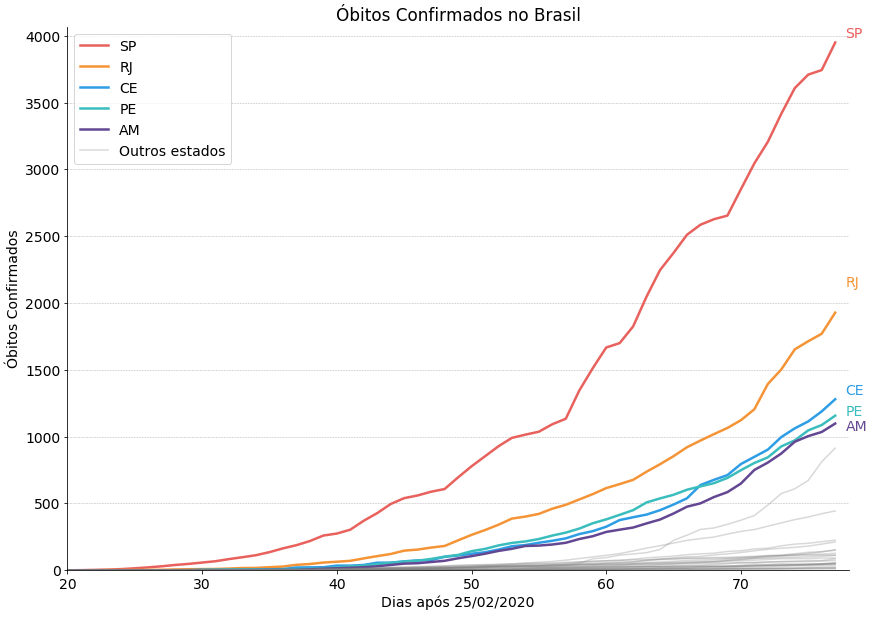

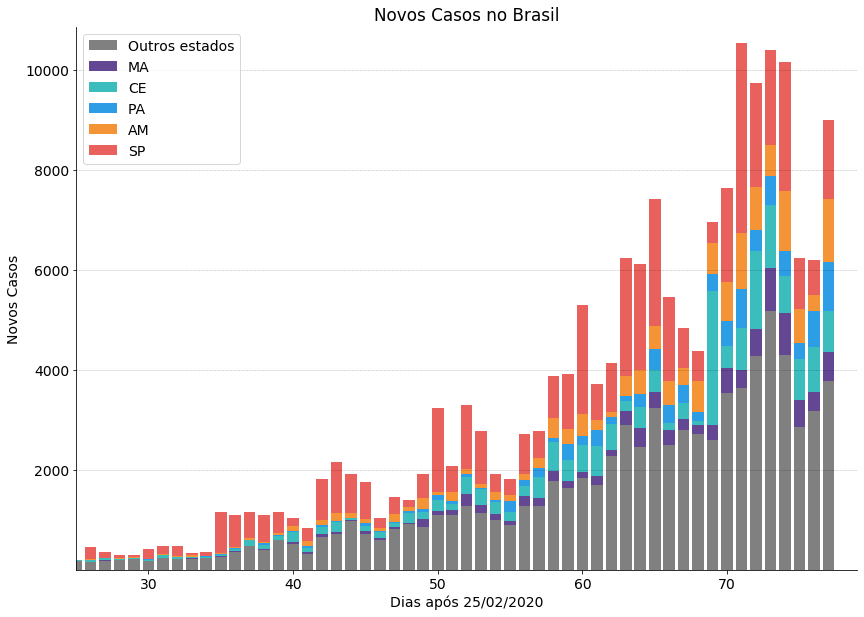

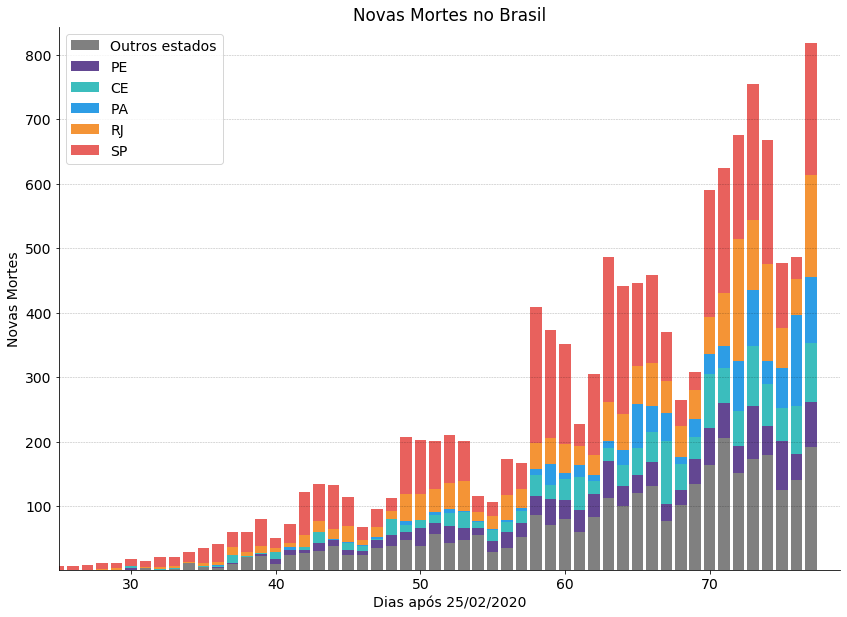

In [12]:
label = ["Estado", "Região", "População", "Último Dado", "Dia", "Casos Confirmados", "Óbitos Confirmados",
         "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]
reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

for f in [5, 6, 7, 8] :
    
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]
    plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                    labelbottom = "on", left = "off", right = "off", labelleft = "on")

    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left() 

    if f in [5, 6] :
        estados = list(df_estados.loc[df_estados['is_last'], :].sort_values(df_estados.columns[f], ascending = False)['state'].unique())

        x_max = max(x)
        y_max = max(y)
        for e in range(27) :
            # Real data
            x = list(df_estados.loc[df_estados['state'] == estados[e], :].iloc[:, 4])
            y = list(df_estados.loc[df_estados['state'] == estados[e], :].iloc[:, f])

            if max(x) > x_max :
                x_max = max(x)
            if max(y) > y_max :
                y_max = max(y)

            ytab = [1.01, 1.1, 1.03, 1, .95]

            if e < 5 :
                plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
                plt.text(max(x) * 1.01, y[-1] * ytab[e], estados[e], color = color[e], fontsize = 14)
            elif e == 5 :
                plt.plot(x, y, marker = ' ', label = 'Outros estados', color = (.5, .5, .5, .3), lw = 1.5)
            else :
                plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)

            plt.xlim(20, x_max + 1)
            plt.ylim(0, y_max * 1.03)
            
    else :        
        estados = list(df_estados.loc[df_estados['is_last'], :].sort_values(df_estados.columns[f], ascending = True)['state'].unique())
        
        x_max = max(df_Brasil.index) + 1
        y_max = max(df_Brasil.iloc[df_Brasil.index, f - 5])
        
        x = list(range(25, max(df_Brasil.index) + 1))
        y = list(df_estados.loc[df_estados['state'] == estados[0], :].iloc[:, f].tail(dia - 24).reset_index(drop = True))

        for r in range(len(Regiao)) :
            if estados[0] in Regiao[r] :
                plt.bar(x, y, color = 'gray')#, edgecolor = (.3, .3, .3, .3))     

        prev = y

        for e in range(1, 27) : 
            y = list(df_estados.loc[df_estados['state'] == estados[e], :].iloc[:, f].tail(dia - 24).reset_index(drop = True))               

            for r in range(len(Regiao)) :    
                if estados[e] in Regiao[r] :
                    if e < 21 :
                        plt.bar(x, y, bottom = prev, color = 'gray')#, edgecolor = (.3, .3, .3, .3))
                    elif e == 21 :
                        plt.bar(x, y, bottom = prev, label = 'Outros estados', color = 'gray')#, edgecolor = (.3, .3, .3, .3))
                    else : 
                        plt.bar(x, y, bottom = prev, label = estados[e], color = color[26 - e])#, edgecolor = (.3, .3, .3, .3))
            prev = [sum(i) for i in zip(y, prev)]

        plt.xlim(25, x_max + 1)
        plt.ylim(1, y_max * 1.03) 
                
    plt.title(label[f] + " no Brasil")
    plt.legend(loc = 2)
    #plt.yscale('log')
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig('Graphics/' + label[f] + " Brasil.png")
    plt.show()

In [13]:
df_estados

,state,region,population,is_last,date,confirmed,deaths,new_confirmed,new_deaths,incidence,death_rate
0,SP,Sudeste,45919049.0,False,0,1,0,1,0,0,0
1,SP,Sudeste,45919049.0,False,1,1,0,0,0,0,0
2,SP,Sudeste,45919049.0,False,2,1,0,0,0,0,0
3,SP,Sudeste,45919049.0,False,3,2,0,1,0,0,0
4,SP,Sudeste,45919049.0,False,4,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1646,RS,Sul,11377239.0,True,77,2917,111,109,6,25.64,3.81
1647,SC,Sul,7164788.0,True,77,3733,73,204,4,52.1,1.96
1648,SE,Nordeste,2298696.0,True,77,2032,37,232,0,88.4,1.82
1649,SP,Sudeste,45919049.0,True,77,47719,3949,1588,206,103.92,8.28


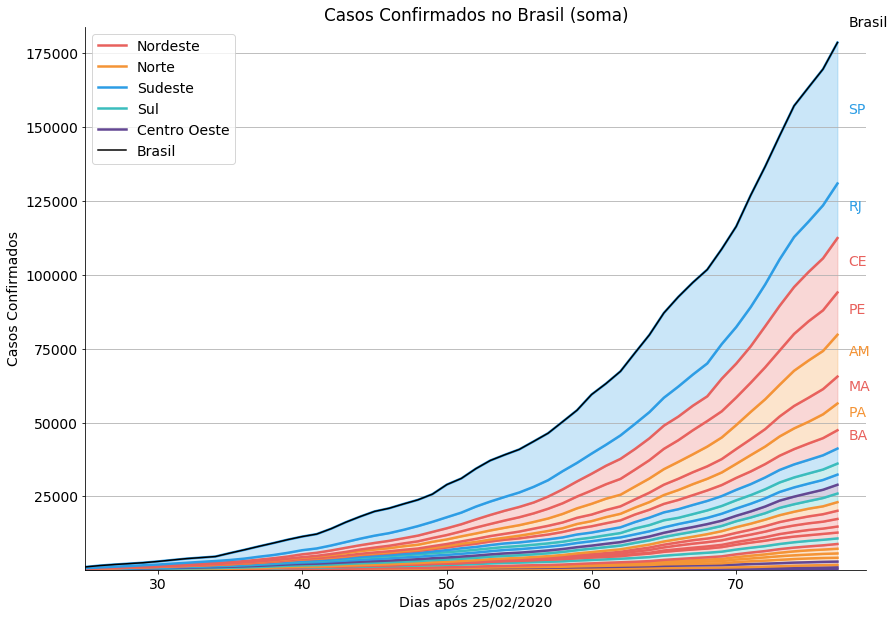

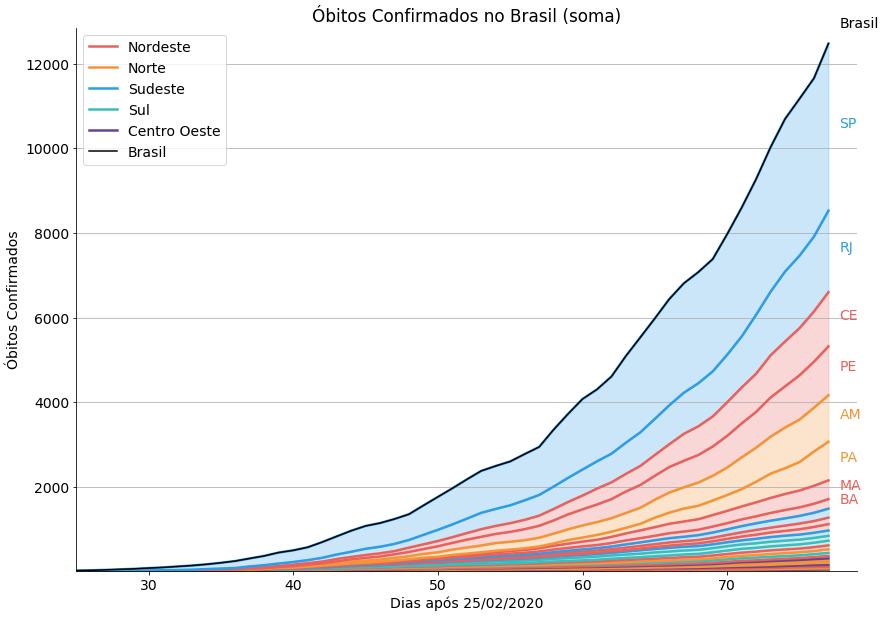

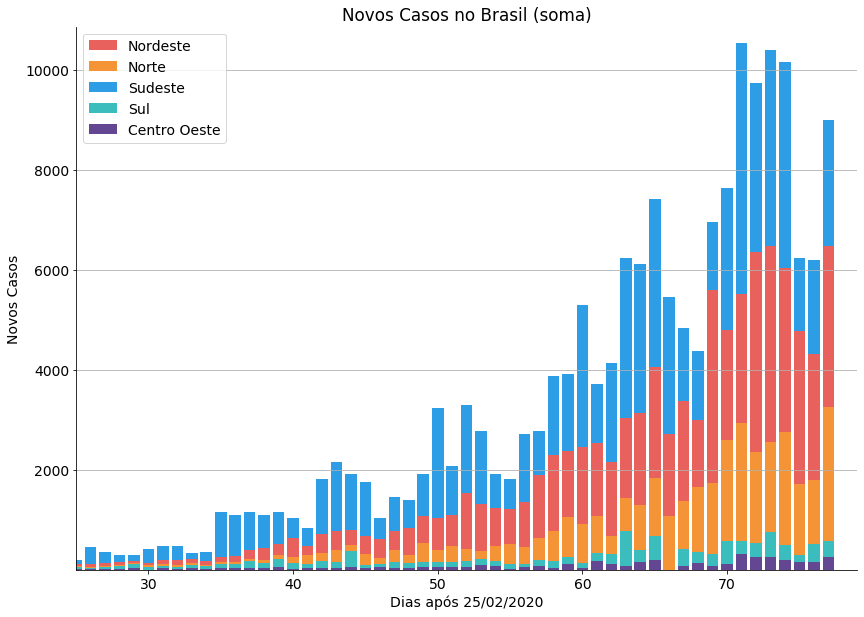

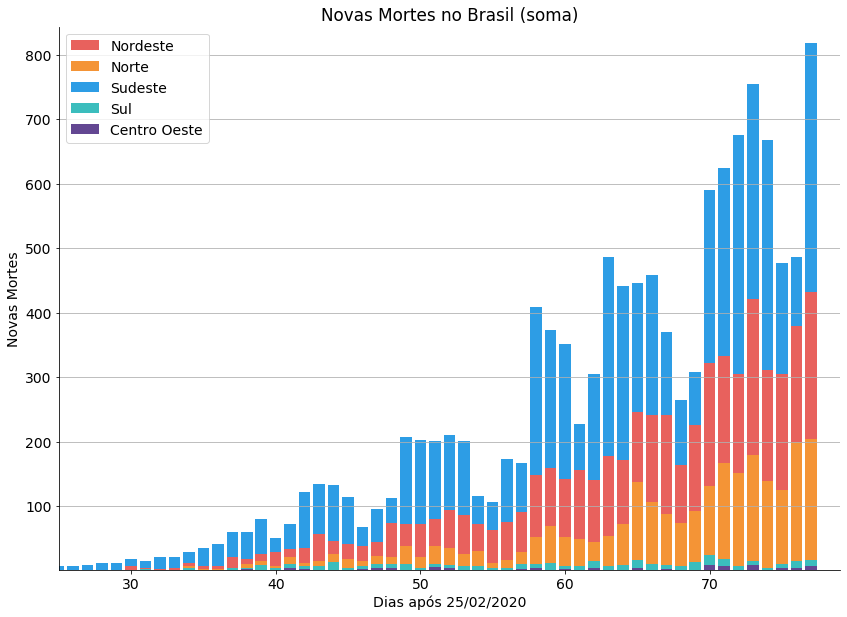

In [14]:
label = ["Estado", "Regiao", "População", "Último Dado","Dia", "Casos Confirmados",
         "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]

dia = max(df_Brasil.index)

for f in [5, 6, 7, 8] :
    
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y')
    
    if f in [5, 6] :
        reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']
        estados = list(df_estados.loc[df_estados['is_last'],
                                      :].sort_values(df_estados.columns[f], ascending = True)['state'].unique())
        
        x_max = dia + 1
        y_max = max(df_Brasil.iloc[df_Brasil.index, f - 5])
        
        x = list(range(25, max(df_Brasil.index) + 1))
        y = list(df_estados.loc[df_estados['state'] == estados[0], :].iloc[:, f].tail(dia - 24).reset_index(drop = True))

        for r in range(len(Regiao)) :
            plt.plot(range(5), range(5), label = reg[r], color = color[r], lw = 2.5)
            if estados[0] in Regiao[r] :
                plt.plot(x, y, marker = ' ', color = color[r], lw = 2.5)     
        temp = list(df_estados.loc[df_estados['state'] == estados[0], :].iloc[:, f].tail(dia - 24).reset_index(drop = True))

        for e in range(1, 27) :                  
            tempa = temp
            tempb = list(df_estados.loc[df_estados['state'] == estados[e], :].iloc[:, f].tail(dia - 24).reset_index(drop = True))               
            y = [sum(i) for i in zip(temp, tempb)]
            temp = y

            for r in range(len(Regiao)) :    
                if estados[e] in Regiao[r] :
                    plt.plot(x, y, marker = ' ', color = color[r], lw = 2.5)
                    if e > 18 :
                        plt.text(max(x) * 1.01, (max(temp) + max(tempa)) * 0.5, estados[e], color = color[r], fontsize = 14)
                    plt.fill_between(x, temp, tempa, color = (color[r] + '40'))

        # Brasil data
        x = range(dia + 1)
        y = list(df_Brasil.iloc[x, f - 5])
        plt.plot(x, y, color = 'black', label = "Brasil", lw = 1.5) 
        plt.text(max(x) * 1.01, y[-1] * 1.03, "Brasil", color = "black", fontsize = 14)               

        plt.xlim(25, x_max + 1)
        plt.ylim(1, y_max * 1.03)
    
    else :
        df_estados['region'] = 'null'
        reg = ['B Nordeste', 'C Norte', 'A Sudeste', 'D Sul', 'E Centro Oeste']
        for r in range(len(Regiao)) :
            for a in range(len(Regiao[r])) :
                df_estados.loc[df_estados['state'].eq(Regiao[r][a]), 'region'] = reg[r]
        
        estados = list(df_estados.loc[df_estados['is_last'],
                                      :].sort_values('region', ascending = False)['state'].unique())
        
        x_max = max(df_Brasil.index) + 1
        y_max = max(df_Brasil.iloc[df_Brasil.index, f - 5])
        
        x = list(range(25, max(df_Brasil.index) + 1))
        y = list(df_estados.loc[df_estados['state'] == estados[0], :].iloc[:, f].tail(dia - 24).reset_index(drop = True))

        for r in range(len(Regiao)) :
            plt.bar(range(1), range(1), label = str(reg[r])[2:], color = color[r])
            if estados[0] in Regiao[r] :
                plt.bar(x, y, color = color[r])#, edgecolor = (.3, .3, .3, .3))     

        prev = y

        for e in range(1, 27) :                
            y = list(df_estados.loc[df_estados['state'] == estados[e], :].iloc[:, f].tail(dia - 24).reset_index(drop = True))               

            for r in range(len(Regiao)) :    
                if estados[e] in Regiao[r] :
                    plt.bar(x, y, bottom = prev, color = color[r])#, edgecolor = (.3, .3, .3, .3))
            prev = [sum(i) for i in zip(y, prev)]
     
        plt.xlim(25, x_max + 1)
        plt.ylim(1, y_max * 1.03)    
        
    plt.title(label[f] + " no Brasil (soma)")
    plt.legend(loc = 2, ncol = 1)
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig('Graphics/' + label[f] + " Brasil soma.png")
    plt.show()


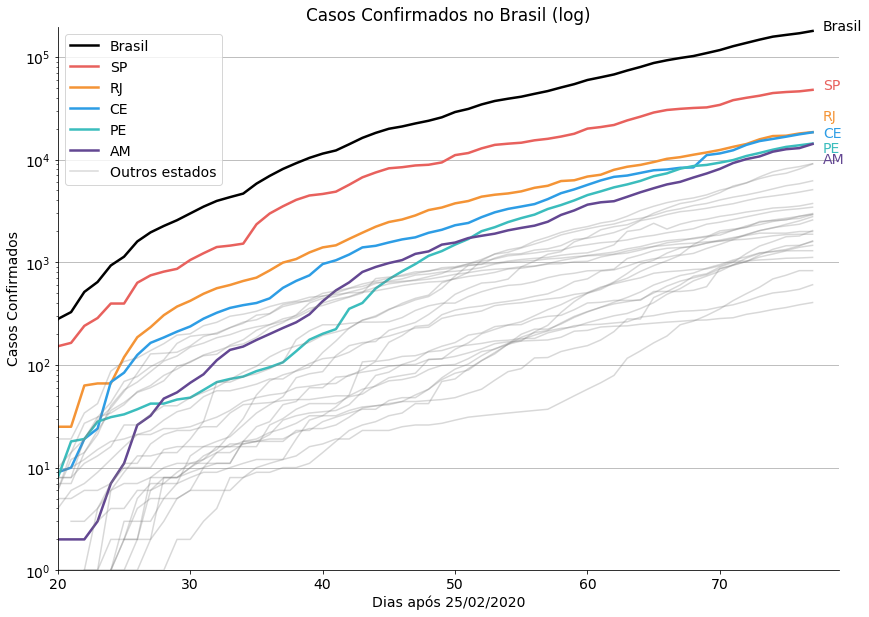

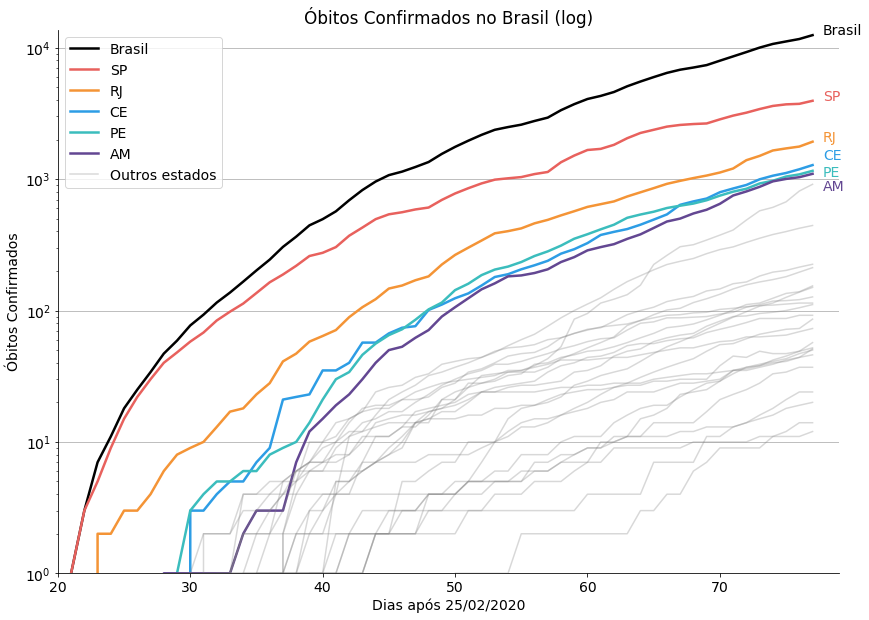

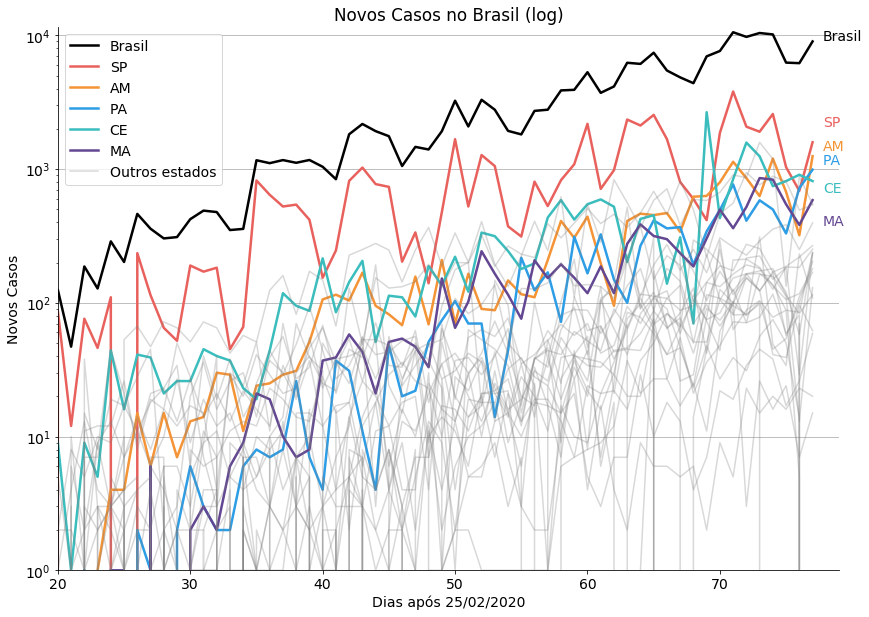

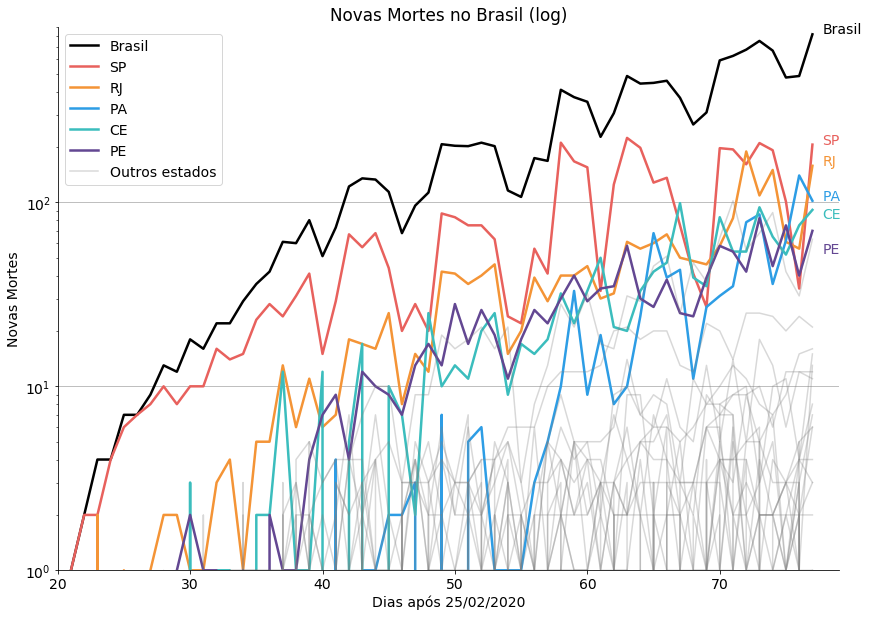

In [17]:
label = ["Estado", "Regiao", "População", "Último Dado", "Dia", "Casos Confirmados",
         "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]
dia = max(df_Brasil.index)

for f in [5, 6, 7, 8] :
    
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y')

    estados = list(df_estados.loc[df_estados['is_last'], :].sort_values(df_estados.columns[f], ascending = False)['state'].unique())
        
    # Brasil data
    x = list(df_Brasil.index)
    x_max = dia + 1

    y = list(df_Brasil.iloc[x, f - 5])
    y_max = max(df_Brasil.iloc[df_Brasil.index, f - 5])
    
    plt.plot(x, y, marker = ' ', color = 'black', label = "Brasil", lw = 2.5) 
    plt.text(max(x) * 1.01, 1.01 * y[-1], "Brasil", color = "black", fontsize = 14)   

    for e in range(27) :  

        x = list(df_estados.loc[df_estados['state'] == estados[e], :].iloc[:, 4])
        y = list(df_estados.loc[df_estados['state'] == estados[e], :].iloc[:, f])
        ytab = [[0], [0], [0], [0], [0],
                [1.01, 1.3, .9, .82, .65], [1.01, 1.01, 1.1, .9, .75],
                [1.3, 1.1, 1.1, .82, .65], [1, 1, 1, .9, .75]]

        if e < 5 :
            plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
            
            if y[-1] > 0 :
                plt.text(max(x) * 1.01, y[-1] * ytab[f][e], estados[e], color = color[e], fontsize = 14)
            elif y[-2] > 0 :
                plt.text(max(x) * 1.01, y[-2] * ytab[f][e] * .1, estados[e], color = color[e], fontsize = 14)
            elif y[-3] > 0 :
                plt.text(max(x) * 1.01, y[-3] * ytab[f][e] * .1, estados[e], color = color[e], fontsize = 14)
        
        elif e == 5 :
            plt.plot(x, y, marker = ' ', label = 'Outros estados', color = (.5, .5, .5, .3), lw = 1.5)
        else :
            plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)

    plt.xlim(20, x_max + 1)
    plt.ylim(1, y_max * 1.1)       
        
    plt.title(label[f] + " no Brasil (log)")
    plt.legend(loc = 2)
    plt.yscale('log')
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig('Graphics/' + label[f] + " Brasil log.png")
    plt.show()
